# Arctic-EDS Data Preparation

## Objectives
This notebook will execute the necessary preprocessing of data prior to being ingested into Rasdaman. The scope of this notebook will cover two "plates" in the original Environmental Atlas of Alaska.

### Plates
#### Mean / Min Max July Temperature
#### Mean / Min / Max January Temperature
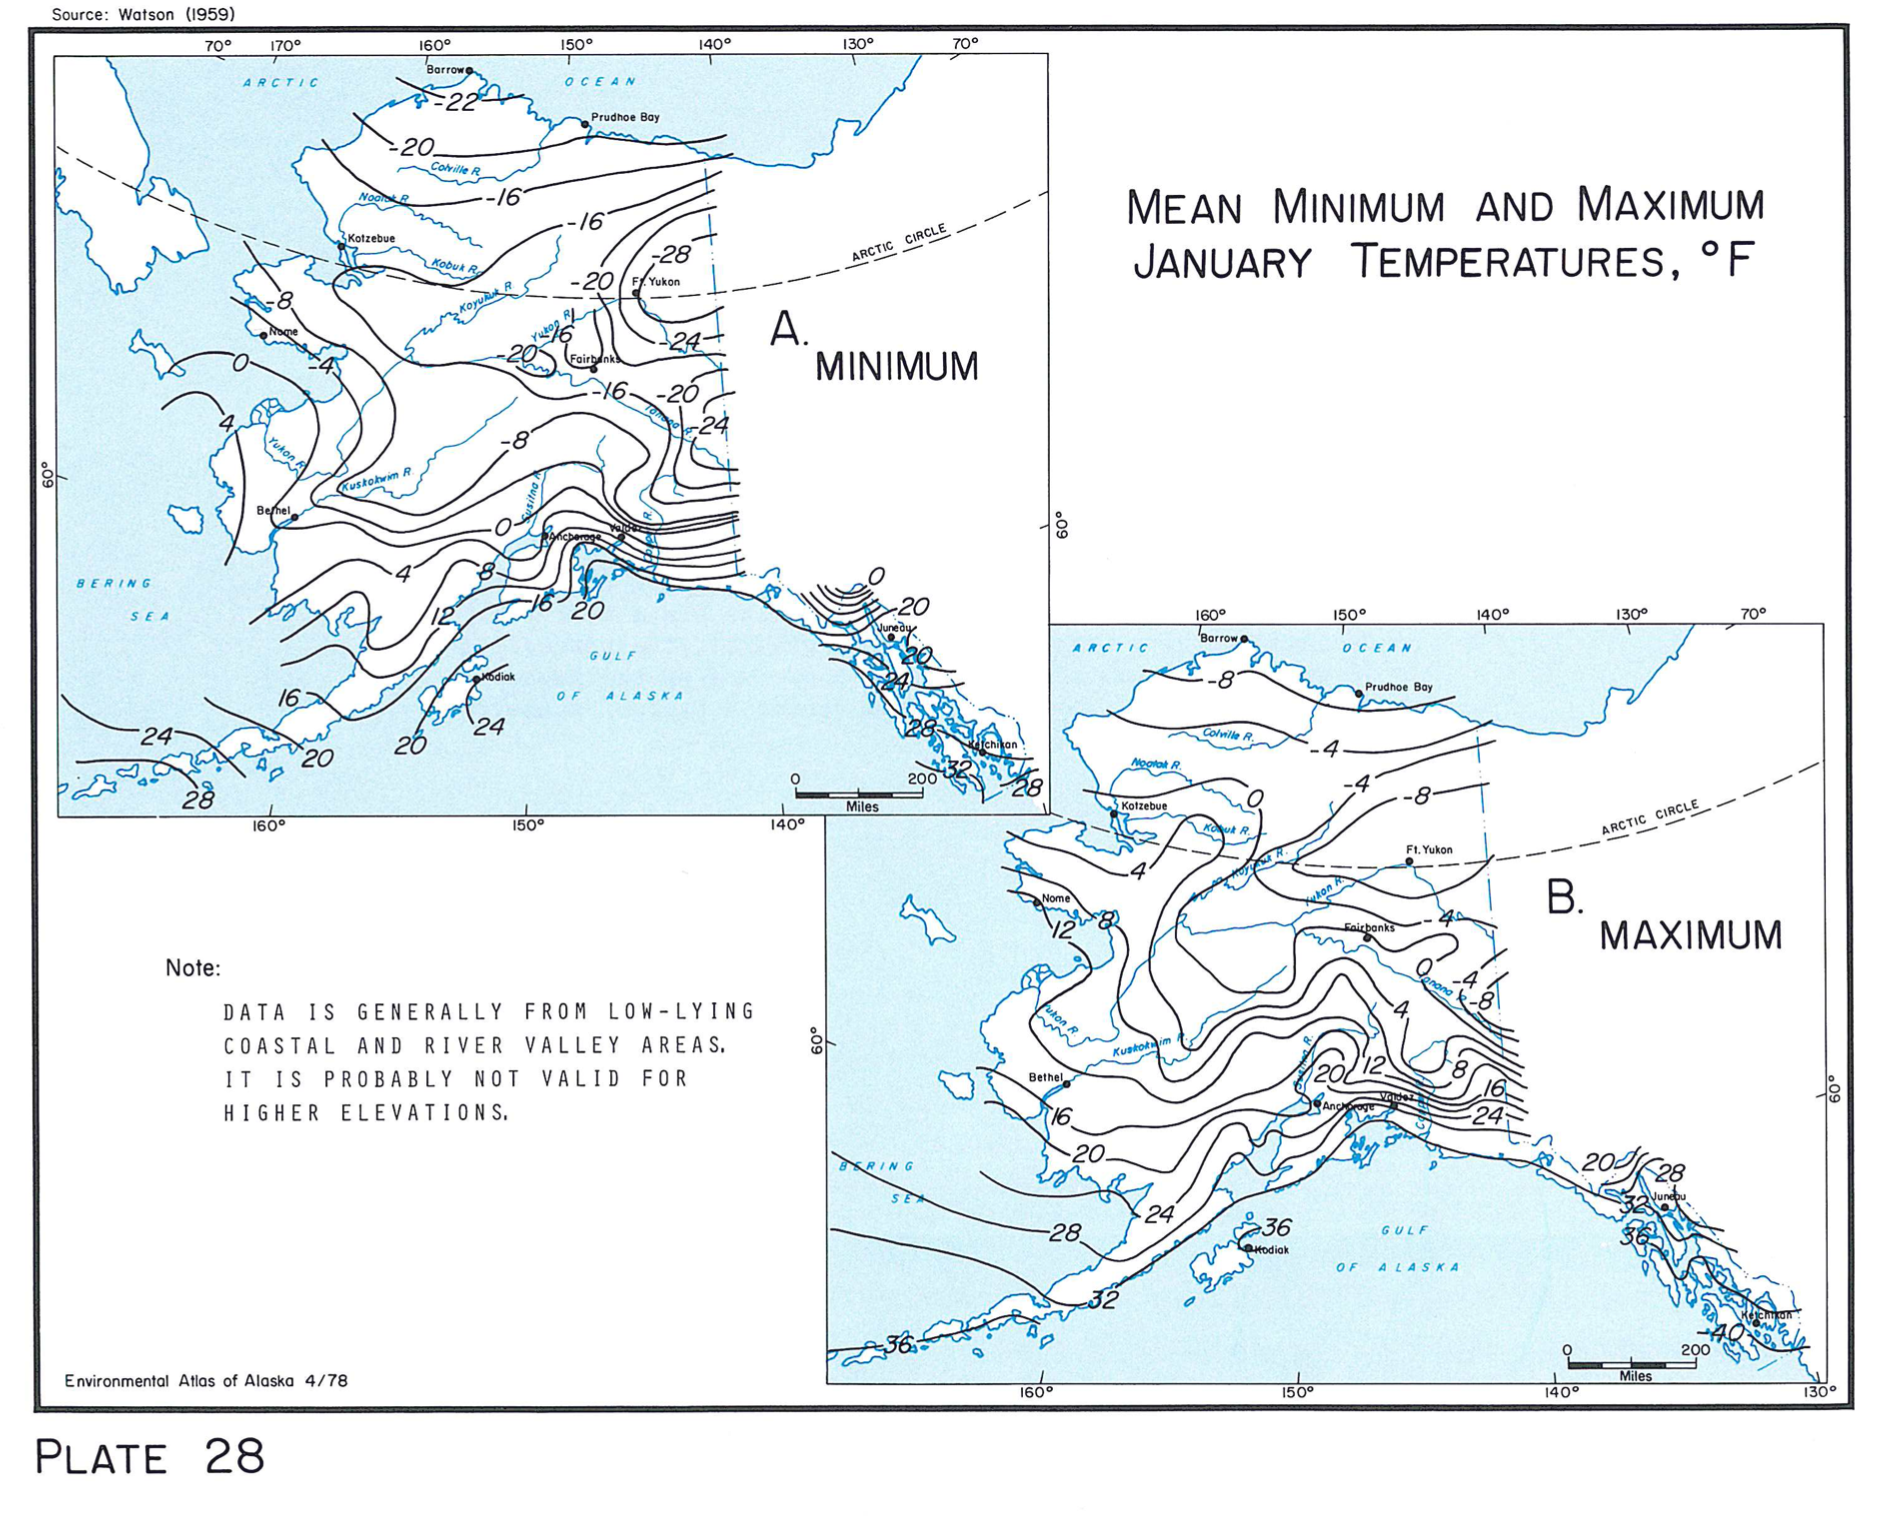

To create modern versions of these plates will want two coverages in Rasdaman, one for each plate (month).

## Replacement Data
There are two datasets that we'll pull from to revamp the above plates.

### Historical 
 - CKAN entry: [Historical Monthly and Derived Temperature Products Downscaled from CRU TS data via the delta method - 2 km](http://ckan.snap.uaf.edu/dataset/historical-monthly-and-derived-temperature-products-downscaled-from-cru-ts-data-via-the-delta-m)
 - This dataset has monthly temperature products downscaled from CRU TS data via the delta method.
 - 2 km spatial resolution.
 - CRU TS version 4.0. These are essentially interpolated observations.
 - Range: 1901 - 2015
 
### Projected
 - CKAN entry: [Projected Monthly and Derived Temperature Products - 2km CMIP5/AR5](http://ckan.snap.uaf.edu/dataset/projected-monthly-and-derived-temperature-products-2km-cmip5-ar5)
 - This dataset has projected monthly temperature products from various CMIP5/AR5 situations.
 - 2 km spatial resolution
 - Scenarios: RCP 4.5, RCP 6.0, RCP 8.5
 - Models: GFDL-CM3, NCAR-CCSM4, GISS-E2-R, MRI-CGCM3, IPSL-CM5A-LR, 5-Model Average
 - Range: 2006 - 2100
 - Downscaling: Delta  with a PRISM 1961 - 1990 baseline.
 
 ### Structure
 Once unzipped, these data are GeoTIFFs where each file is a single month of a single year for a single model/scenario (or historical) combination.

For the january coverage we'll want a coverage in Rasdaman with the following axes (besides x and y):
 - Year
 - Model
 - Scenario
 - Temperature Statistic (one of mean, minimum, or maximum).

## Processing
We don't actually need to do much because this dataset is already "production-grade" - meaning it used in other apps and is a seminal dataset in our CKAN data portal. We will need to grab the data, so that means running some commands to shuffle data around. I recommend you jump on an *ATLAS* compute node to do the data shuffle.

```sh
cd $YOUR_SCRATCH_DIRECTORY

cp -r /workspace/CKAN/CKAN_Data/Base/AK_CAN_2km/projected/AR5_CMIP5_models/Projected_Monthly_and_Derived_Temperature_Products_2km_CMIP5_AR5/monthly/ .

# This will take a while - go get some fresh air.
unzip \*.zip

# Verify the GeoTIFFs extracted consistently
 ls tasmin/tasmin_mean_C_ar5_*_01_* | wc -l
 ls tasmin/tasmin_mean_C_ar5_*_07_* | wc -l
 ls tasmax/tasmax_mean_C_ar5_*_07_* | wc -l
 ls tasmax/tasmax_mean_C_ar5_*_01_* | wc -l
 ls tas/tas_mean_C_ar5_*_01_* | wc -l
 ls tas/tasmean_C_ar5_*_01_* | wc -l
 ls tas/tas_mean_C_AR5_*_01_* | wc -l
 ls tas/tas_mean_C_AR5_*_07_* | wc -l

# Each month and temperature statistic combination should have 1710 GeoTIFFs (6 models X 3 scenarios X 95 years).

# Get these data ready to transfer over to one of the Rasdaman servers (Zeus or Apollo).
mkdir jan
mkdir july
# Steady now...no guardrails on this mv
mv tas/tas_mean_C_AR5_*_07_* july/
mv tasmin/tasmin_mean_C_ar5_*_07_* july
mv tasmax/tasmax_mean_C_ar5_*_07_* july
mv tasmin/tasmin_mean_C_ar5_*_01_* jan/
mv tasmax/tasmax_mean_C_ar5_*_01_* jan/
mv tas/tas_mean_C_AR5_*_01_* jan/

# Now to the same with historical data
cp -r /workspace/CKAN/CKAN_Data/Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Temperature_Products_2km_CRU_TS/tasmax_AK_CAN_2km_CRU_TS40_historical.zip .
cp -r /workspace/CKAN/CKAN_Data/Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Temperature_Products_2km_CRU_TS/tasmin_AK_CAN_2km_CRU_TS40_historical.zip .
cp -r /workspace/CKAN/CKAN_Data/Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Temperature_Products_2km_CRU_TS/tas_AK_CAN_2km_CRU_TS40_historical.zip .

unzip \*historical.zip

# Verify 
ls tas/*historical_01_* | wc -l
116
ls tas/*historical_07_* | wc -l
115
ls tasmin/*historical_07_* | wc -l
115
ls tasmax/*historical_07_* | wc -l
115
ls tasmax/*historical_01_* | wc -l
115
ls tasmin/*historical_01_* | wc -l
115

# OK it is a little odd there are 116 GeoTIFFs for the mean historical January temperatures...let's move these files and take a closer look.

mv tasmin/*historical_01_* jan/
mv tasmax/*historical_01_* jan/
mv tas/*historical_01_* jan/
mv tas/*historical_07_* july
mv tasmin/*historical_07_* july
mv tasmax/*historical_07_* july

# An xml file snuck in there (hello GIS!) and should be deleted. 
rm jan/tas_mean_C_CRU_TS40_historical_01_1902.tif.aux.xml

```
Woo! Ok now `jan` and `july` should have the same numer of files (5475) and data volume (14G) within. 

Let's look at the file naming convention because that will dictate the ingest and we should strive for consistency between how the historical and projected data are named.

tasmin_mean_C_CRU-TS40_historical_07_2003.tif

tasmin_mean_C_ar5_5ModelAvg_rcp60_07_2039.tif

tas_mean_C_AR5_GFDL-CM3_rcp45_07_2099.tif

tasmax_mean_C_ar5_MRI-CGCM3_rcp60_07_2006.tif

tasmax_mean_C_ar5_5ModelAvg_rcp45_07_2014.tif

tas_mean_C_CRU_TS40_historical_07_1938.tif

I don't love these file names. "mean_C" and "AR5" or "ar5" are redundant. I think we can rename these to be more succinct and consistent for a naming convention that reads "tasvariable_model_scenario_year" where "tasvariable" is either tasmin, tasmax, or tasmean. For the historical "model" we can use "CRU-TS" and for the "scenario" we'll retain "historical" - and that syntax is consistent with what we have in other data coverages.

Historical renaming (do this in both `jan` and `july`) and remove "echo" if the command output looks correct (again, mv-ing with no guardrails here so keep your head on a swivel out there). You can also pipe the command as is to bash to actually execute it.


```sh
 for f in *historical*; do echo mv "$f" "${f/_mean_C_/_}"; done
 
 for f in *historical*; do echo mv "$f" "${f/TS40/TS}"; done
 
 for f in *historical*; do echo mv "$f" "${f/historical_07/historical}"; done
 
 for f in *tas_CRU*; do echo mv "$f" "${f/tas_CRU_TS/tasmean_CRU-TS}"; done
```

For the projected file names, we can just remove the redundant pieces and drop the numeric month indicator.

```sh
for f in *ar5*; do echo mv "$f" "${f/_mean_C_ar5/}"; done
for f in *AR5*; do echo mv "$f" "${f/_mean_C_AR5/}"; done
for f in *rcp*; do echo mv "$f" "${f/_01_/_}"; done
for f in *tas_*; do echo mv "$f" "${f/tas_/tasmean_}"; done
for f in *5Mo*; do echo mv "$f" "${f/5Mo/5mo}"; done

```

OK at this point these data are basically ready for ingest!
The data now need to be moved to a Rasdaman server (Apollo, Zeus).



```sh
scp -r jan/ cparr4@apollo.snap.uaf.edu:
scp -r july/ cparr4@apollo.snap.uaf.edu:
```
will put the directories of data in your home directory on the machine.


TODO: force 3338 to fix potential gdalinfo issues
      force correct (-9999) no data values
      
`(justgdal) bash-4.2$ for f in *.tif; do echo gdalwarp -t_srs EPSG:3338 "$f" "${f%.*}_3338.tif" ; done`

In [2]:
import fnmatch
import os

def listdir(dirname, pattern="*.tif"):
    return fnmatch.filter(os.listdir(dirname), pattern)


In [17]:
flist = listdir("/atlas_scratch/cparr4/arcticeds/monthly/jan/")

In [25]:
flist[0]

'tasmin_5ModelAvg_rcp45_2008.tif'

In [30]:
yr = [x.split("_")[1] for x in flist]

In [31]:
(set(yr))

{'5ModelAvg',
 '5modelAvg',
 'CCSM4',
 'CRU-TS',
 'GFDL-CM3',
 'GISS-E2-R',
 'IPSL-CM5A-LR',
 'MRI-CGCM3',
 'NCAR-CCSM4'}